В этой тетрадке я предпринимаю отчаянную попытку перевести на ржя через модель mt5

In [1]:
#!g1.1
%pip install transformers sentencepiece
%pip install simpletransformers
%pip install pympi-ling
%pip install razdel

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 249 kB 3.3 MB/s            
     |████████████████████████████████| 10.1 MB 42.2 MB/s            
     |████████████████████████████████| 342 kB 75.3 MB/s            
     |████████████████████████████████| 43 kB 2.1 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 4.2 MB 65.2 MB/s            
     |████████████████████████████████| 6.6 MB 69.9 MB/s            
     |████████████████████████████████| 29.4 MB 57.1 MB/s            
     |████████████████████████████████| 128 kB 94.5 MB/s            
     |████████████████████████████████| 78 kB 5.6 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 8

In [2]:
#!g1.1
%pip install torchtext

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.4 MB 3.3 MB/s            
     |████████████████████████████████| 750.6 MB 5.9 kB/s              
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.5.10 requires setuptools==59.5.0, but you have setuptools 51.0.0 which is incompatible.
torchvision 0.10.1+cu111 requires torch==1.9.1, but you have torch 1.11.0 which is incompatible.
torchaudio 0.9.1 requires torch==1.9.1, but you have torch 1.11.0 which is incompatible.
You should consider upgrading via the '/usr/loca

In [ ]:
#!unzip Разметки.zip

In [1]:
#!g1.1
import pandas as pd
import numpy as np
import pympi
from razdel import tokenize
from sklearn.model_selection import train_test_split
#from torchtext.legacy import data
import torchtext.vocab as vocab
import torch

In [2]:
#!g1.1
# check if cuda is on
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False

True

## Загрузка данных

Загружаем данные, потом делим их на трейн и тест и сохраняем в соответствующие два файла

In [2]:
#!g1.1
import re
import json
import pymystem3
import os, sys
sys.path.append('../')
from argparse import Namespace

from pyeaf.pyeaf import EAFReader
from pyeaf.text import VocabularyVectorizer, TextStemmer, RSLStemmer, GramBinarizer

In [105]:
"""
def save_data(train, test, format_save="csv"):
    # Save rsl_sentences and rus_sentences to csv or json
    if format_save == 'json':
        with open('train.json', 'w', encoding='utf-8') as file:
            train.to_json(file, orient='records', lines=True, force_ascii=False)
        with open('test.json', 'w', encoding='utf-8') as file:
            test.to_json(file, orient='records', lines=True, force_ascii=False)
    elif format_save == 'csv':
        with open('train.csv', 'w', encoding='utf-8') as file:
            train.to_csv(file, index=False)
        with open('test.csv', 'w', encoding='utf-8') as file:
            test.to_csv(file, index=False)
"""

### Take replacements_less_repeat and sv\svo data in proportion 70/30

### Load replacements data

In [3]:
#!g1.1
generated_data = pd.read_csv('generated_stemed_less_repetitions.csv', encoding='utf-8')

generated_data['stem_rus'] = generated_data['new_stem_sent_rus'].apply(lambda sent: sent.strip('[]\'').split('\', \''))
generated_data['rsl'] = generated_data['new_stem_rsl'].apply(lambda sent: sent.strip('[]\'').split('\', \''))
generated_data['gram_rus'] = generated_data['new_gram_sent_rus'].apply(lambda sent: json.loads(sent.replace('\'', '\"')))

In [4]:
#!g1.1
for index, row in generated_data.iterrows():
    if row['rsl'] == ['']:
        generated_data.drop(index, inplace=True)

In [5]:
#!g1.1
test_data = pd.read_csv('test_data.csv', encoding='utf-8')

test_data['stem_rus'] = test_data['test_stem_rus'].apply(lambda sent: sent.strip('[]\'').split('\', \''))
test_data['rsl'] = test_data['test_rsl'].apply(lambda sent: sent.strip('[]\'').split('\', \''))
test_data['gram_rus'] = test_data['test_gram_rus'].apply(lambda sent: json.loads(sent.replace('\'', '\"')))

In [6]:
#!g1.1
for index, row in test_data.iterrows():
    if row['rsl'] == ['']:
        test_data.drop(index, inplace=True)

In [7]:
#!g1.1
generated_data.tail()

,new_stem_sent_rus,new_gram_sent_rus,new_stem_rsl,stem_rus,rsl,gram_rus
10511,"['скитаться', 'бездельничать', 'вмешиваться', ...","[['V', 'инф', 'несов', 'нп'], ['V', 'инф', 'не...","['скитаться', 'бездельничать', 'вмешиваться', ...","[скитаться, бездельничать, вмешиваться, и, я, ...","[скитаться, бездельничать, вмешиваться, говори...","[[V, инф, несов, нп], [V, инф, несов, нп], [CO..."
10513,"['сестра', 'быть', 'танцевать', 'с', 'принц', ...","[['од', 'им', 'ед', 'род', 'мн', 'жен', 'S'], ...","['сестра', 'двое', 'будет', 'танцевать', 'вмес...","[сестра, быть, танцевать, с, принц, а, обо, я,...","[сестра, двое, будет, танцевать, вместе2, прин...","[[од, им, ед, род, мн, жен, S], [изъяв, непрош..."
10514,"['героиня', 'клип', 'возвращаться', 'подтвержд...","[['од', 'им', 'ед', 'жен', 'S'], ['V', 'инф', ...","['героиня', 'клип', 'возвращаться', 'будет', '...","[героиня, клип, возвращаться, подтверждать, с,...","[героиня, клип, возвращаться, будет, подтвержд...","[[од, им, ед, жен, S], [V, инф, несов, нп], [V..."
10515,"['мамка', 'жучок', 'умирать', 'измерять', 'с',...","[['од', 'им', 'ед', 'жен', 'S'], ['V', 'инф', ...","['мамка', 'жучок', 'умирать', 'будет', 'измеря...","[мамка, жучок, умирать, измерять, с, сын, три,...","[мамка, жучок, умирать, будет, измерять, вмест...","[[од, им, ед, жен, S], [V, инф, нп, сов], [V, ..."
10516,"['племянница', 'доминировать', 'ударять', 'с',...","[['од', 'им', 'ед', 'род', 'мн', 'жен', 'S'], ...","['племянница', 'доминировать', 'будет', 'ударя...","[племянница, доминировать, ударять, с, сотрудн...","[племянница, доминировать, будет, ударять, вме...","[[од, им, ед, род, мн, жен, S], [V, инф, несов..."


Теперь мы можем настроить логгирование и загрузить модельку для русского вот отсюда:

https://huggingface.co/cointegrated/rut5-small

Я беру именно эту, потому что там только русский язык и моделька маленькая, значит, моя память это потянет.

In [8]:
#!g1.1
import logging
#from simpletransformers.t5 import T5Model, T5Args
from transformers import T5ForConditionalGeneration, T5Tokenizer

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

tokenizer = T5Tokenizer.from_pretrained("cointegrated/rut5-small")
tokenizer.add_special_tokens({'additional_special_tokens': ["clf", "poss", "sg", "<nums>", "<dact>", "1ps", "2ps", "3ps", "indx", "pl"]})
#model = T5ForConditionalGeneration.from_pretrained("cointegrated/rut5-small")

Downloading:   0%|          | 0.00/625k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

9

Теперь достаем данные снова

In [8]:
#!g1.1
generated_data['input_text'] = generated_data['stem_rus'].apply(' '.join)
generated_data['target_text'] = generated_data['rsl'].apply(' '.join)

In [9]:
#!g1.1
test_data['input_text'] = test_data['stem_rus'].apply(' '.join)
test_data['target_text'] = test_data['rsl'].apply(' '.join)

In [10]:
#!g1.1
generated_data['prefix'] = ''
test_data['prefix'] = ''

In [11]:
#!g1.1
test_data.head()

,test_stem_rus,test_gram_rus,test_rsl,stem_rus,rsl,gram_rus,input_text,target_text,prefix
0,"['а', 'когда', 'дед', 'мороз', 'вернуться', 'д...","[['CONJ'], ['CONJ'], ['им', 'мн', 'S', 'муж', ...","['indx', 'дед.мороз', 'clf', 'clf.группа', 'cl...","[а, когда, дед, мороз, вернуться, домой, мален...","[indx, дед.мороз, clf, clf.группа, clf.перемес...","[[CONJ], [CONJ], [им, мн, S, муж, од], [им, мн...",а когда дед мороз вернуться домой маленький де...,indx дед.мороз clf clf.группа clf.переместить ...,
1,"['а', 'мачеха', 'лишать', 'я', 'весь', 'радость']","[['CONJ'], ['им', 'S', 'од', 'жен', 'ед'], ['и...","['мама', 'второй', '3ps', 'все', 'радость', 'д...","[а, мачеха, лишать, я, весь, радость]","[мама, второй, 3ps, все, радость, давать, 1ps,...","[[CONJ], [им, S, од, жен, ед], [изъяв, V, пе, ...",а мачеха лишать я весь радость,мама второй 3ps все радость давать 1ps ноль,
4,"['зачем', 'я', 'хотеть', 'изменять', 'свой', '...","[['ADVPRO'], ['им', 'ед', '1-л', 'SPRO'], ['из...","['зачем', 'желание', 'изменение', 'все4', 'при...","[зачем, я, хотеть, изменять, свой, привычка, т...","[зачем, желание, изменение, все4, привычка, тр...","[[ADVPRO], [им, ед, 1-л, SPRO], [изъяв, V, пе,...",зачем я хотеть изменять свой привычка тратить ...,зачем желание изменение все4 привычка тратить ...,
5,"['оказываться', 'впервые', 'это', 'появляться'...","[['изъяв', 'V', '3-л', 'нп', 'несов', 'ед', 'н...","['америка', 'есть', 'poss', '3ps', '3ps', 'рас...","[оказываться, впервые, это, появляться, в, аме...","[америка, есть, poss, 3ps, 3ps, рассказ, 1ps, ...","[[изъяв, V, 3-л, нп, несов, ед, непрош], [ADV]...",оказываться впервые это появляться в америка,америка есть poss 3ps 3ps рассказ 1ps интересн...,
6,"['я', 'вчера', 'не', 'стирать', 'белье']","[['им', 'ед', '1-л', 'SPRO'], ['ADV'], ['PART'...","['1ps', 'вчера', 'стирать', '<dact>', 'не', 'б...","[я, вчера, не, стирать, белье]","[1ps, вчера, стирать, <dact>, не, был]","[[им, ед, 1-л, SPRO], [ADV], [PART], [изъяв, V...",я вчера не стирать белье,1ps вчера стирать <dact> не был,


### Load task-agnostic generated data

In [12]:
#!g1.1
# task-agnostic data
agnostic_data = pd.read_csv('generated_data_task_agnostic.csv', encoding='utf-8')

In [13]:
#!g1.1
agnostic_data.head()

,Unnamed: 0,rsl,rus,lemmatized,input_text,target_text
0,0,"['отступление', 'германец', 'и', 'сопоцкин', '...",Бои у Сопоцкина и Друскеник закончились отступ...,"['бой', 'у', 'сопоцкин', 'и', 'друскеник', 'за...",Бои у Сопоцкина и Друскеник закончились отступ...,отступление германец и сопоцкин заканчиваться ...
1,1,"['осовец', 'неприятель', 'артиллерийский', 'кр...","Неприятель, приблизившись с севера к Осовцу на...","['неприятель', 'приближаться', 'с', 'север', '...","Неприятель, приблизившись с севера к Осовцу на...",осовец неприятель артиллерийский крепость борь...
2,2,"['участие', 'тяжелый', 'калибр', 'в', 'принима...",В артиллерийском бою принимают участие тяжелые...,"['в', 'артиллерийский', 'бой', 'принимать', 'у...",В артиллерийском бою принимают участие тяжелые...,участие тяжелый калибр в принимать артиллерийс...
3,3,"['сентябрь', 'достигать', 'с', 'огонь', 'ранни...",С раннего утра 14 сентября огонь достиг значит...,"['с', 'ранний', 'утро', 'сентябрь', 'огонь', '...",С раннего утра 14 сентября огонь достиг значит...,сентябрь достигать с огонь ранний утро напряже...
4,4,"['попытка', 'крепость', 'пехота', 'германский'...",Попытка германской пехоты пробиться ближе к кр...,"['попытка', 'германский', 'пехота', 'пробивать...",Попытка германской пехоты пробиться ближе к кр...,попытка крепость пехота германский отражать к ...


In [14]:
#!g1.1
agnostic_data['prefix'] = ''
test_data['prefix'] = ''

In [ ]:
#!g1.1

### Load svo\sv data

In [15]:
#!g1.1
rared_good = pd.read_csv("rared_good_fake_sents.tsv", sep="\t", names=['rus', 'rsl', 'pred'])
rared_good.tail()

,rus,rsl,pred
18996,Сирота создаёт сокращение.,сирота создавать сокращение,0.506723
18997,Сирота стреляет проверка контроль.,сирота стрелять проверка контроль,0.510003
18998,Сирота транспортирует проверка контроль.,сирота транспортировать проверка контроль,0.510003
18999,Сирота узнаёт уверенность.,сирота узнавать уверенность,0.504941
19000,Сирота усиливает проверка контроль.,сирота усиливать проверка контроль,0.510003


In [16]:
#!g1.1
rared_good['input_text'] = rared_good['rus']
rared_good['target_text'] = rared_good['rsl']

In [17]:
#!g1.1
rared_good['prefix'] = ''
#test_data['prefix'] = ''
#test_data['input_text'] = test_data['stem_rus'].apply(' '.join)
#test_data['target_text'] = test_data['rsl'].apply(' '.join)

### Concat replacements less repeatitions dataset with svo\sv dataset

In [18]:
#!g1.1
rared_good.drop(['rus', 'rsl', 'pred'], axis=1, inplace=True)  

In [19]:
#!g1.1
rared_good.head()

,input_text,target_text,prefix
0,"Или, например, человек хочет после вставать, ч...",есть тоже люди кто желание после вставать2 что...,
1,"Например, скоро, на предприятии вог, на швейно...",что скоро пример завод вог завод шить2 шить3 п...,
2,"Да, мы после хотели.",indx желание после indx да :pl,
3,"Вообще, мы рано думали что нужно добавить жест...",результат indx рано думать что необходимость ж...,
4,Дочь достигает.,Дочь достигать,


In [20]:
#!g1.1
# take 30,11% of svo\sv data so that final mix it is 40\60
len(agnostic_data) * 0.4834

9668.0

In [21]:
#!g1.1
agnostic_data.iloc[:9688]

,Unnamed: 0,rsl,rus,lemmatized,input_text,target_text,prefix
0,0,"['отступление', 'германец', 'и', 'сопоцкин', '...",Бои у Сопоцкина и Друскеник закончились отступ...,"['бой', 'у', 'сопоцкин', 'и', 'друскеник', 'за...",Бои у Сопоцкина и Друскеник закончились отступ...,отступление германец и сопоцкин заканчиваться ...,
1,1,"['осовец', 'неприятель', 'артиллерийский', 'кр...","Неприятель, приблизившись с севера к Осовцу на...","['неприятель', 'приближаться', 'с', 'север', '...","Неприятель, приблизившись с севера к Осовцу на...",осовец неприятель артиллерийский крепость борь...,
2,2,"['участие', 'тяжелый', 'калибр', 'в', 'принима...",В артиллерийском бою принимают участие тяжелые...,"['в', 'артиллерийский', 'бой', 'принимать', 'у...",В артиллерийском бою принимают участие тяжелые...,участие тяжелый калибр в принимать артиллерийс...,
3,3,"['сентябрь', 'достигать', 'с', 'огонь', 'ранни...",С раннего утра 14 сентября огонь достиг значит...,"['с', 'ранний', 'утро', 'сентябрь', 'огонь', '...",С раннего утра 14 сентября огонь достиг значит...,сентябрь достигать с огонь ранний утро напряже...,
4,4,"['попытка', 'крепость', 'пехота', 'германский'...",Попытка германской пехоты пробиться ближе к кр...,"['попытка', 'германский', 'пехота', 'пробивать...",Попытка германской пехоты пробиться ближе к кр...,попытка крепость пехота германский отражать к ...,
...,...,...,...,...,...,...,...
9683,9683,"['по', 'схема', 'предполагаться', 'клонировани...","Клонирование предполагается провести по схеме,...","['клонирование', 'предполагаться', 'проводить'...","Клонирование предполагается провести по схеме,...",по схема предполагаться клонирование два назад...,
9684,9684,"['от', 'зародыш', 'который', 'быть', 'затем', ...","Яйцеклетку, в которую будет введено клеточное ...","['яйцеклетка', 'в', 'который', 'быть', 'вводит...","Яйцеклетку, в которую будет введено клеточное ...",от зародыш который быть затем матка который вз...,
9685,9685,"['родиться', 'от', 'полумамонт', 'скрещивание'...",От такого скрещивания родится полуслон-полумам...,"['от', 'такой', 'скрещивание', 'родиться', 'по...",От такого скрещивания родится полуслон-полумам...,родиться от полумамонт скрещивание такой полуслон,
9686,9686,"['сам', 'мамонт', 'исследовать', 'ученый', 'на...",Ученые намерены подробно исследовать самого ма...,"['ученый', 'намерен', 'подробно', 'исследовать...",Ученые намерены подробно исследовать самого ма...,сам мамонт исследовать ученый намерен подробно,


In [22]:
#!g1.1
generated_data.drop(['new_stem_sent_rus', 'new_gram_sent_rus', 'new_stem_rsl', 'stem_rus', 'rsl', 'gram_rus'], axis=1, inplace=True)

In [23]:
#!g1.1
generated_data.head()

,input_text,target_text,prefix
3,рано я не любить молоко,раньше молоко 1ps не.любить,
4,рано я не гражданин животное,раньше животное 1ps гражданин,
5,рано я не житель наш родной город животное,раньше животное 1ps житель наш родной город,
7,приезжать в деревня а там нет электричество,деревня путешествие ; ничего3 электричество не...,
8,отвечать в рыба много жир в хвост а там нет чу...,отвечать путешествие рыба много жир в хвост ни...,


In [24]:
#!g1.1
agnostic_data.drop(['rus', 'rsl', 'lemmatized', 'Unnamed: 0'], axis=1, inplace=True)  

In [25]:
#!g1.1
agnostic_data.head()

,input_text,target_text,prefix
0,Бои у Сопоцкина и Друскеник закончились отступ...,отступление германец и сопоцкин заканчиваться ...,
1,"Неприятель, приблизившись с севера к Осовцу на...",осовец неприятель артиллерийский крепость борь...,
2,В артиллерийском бою принимают участие тяжелые...,участие тяжелый калибр в принимать артиллерийс...,
3,С раннего утра 14 сентября огонь достиг значит...,сентябрь достигать с огонь ранний утро напряже...,
4,Попытка германской пехоты пробиться ближе к кр...,попытка крепость пехота германский отражать к ...,


In [27]:
#!g1.1
# concatenate

mixed_data_agn_forty = pd.concat([generated_data, rared_good, agnostic_data.iloc[:9688]], ignore_index=True)

In [28]:
#!g1.1
mixed_data_agn_forty.head()

,input_text,target_text,prefix
0,рано я не любить молоко,раньше молоко 1ps не.любить,
1,рано я не гражданин животное,раньше животное 1ps гражданин,
2,рано я не житель наш родной город животное,раньше животное 1ps житель наш родной город,
3,приезжать в деревня а там нет электричество,деревня путешествие ; ничего3 электричество не...,
4,отвечать в рыба много жир в хвост а там нет чу...,отвечать путешествие рыба много жир в хвост ни...,


In [29]:
#!g1.1
len(mixed_data_agn_forty)

37272

### Переходим к обучению

Зафайнтьюненная модель будет сохранена в папке `outputs` по дефолту. (https://simpletransformers.ai/docs/tips-and-tricks/#saving-checkpoints)

In [30]:
#!g1.1
import wandb

In [29]:
#!g1.1
wandb.login(relogin)

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  *******


wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [31]:
#!g1.1
from simpletransformers.t5 import T5Model, T5Args

use_cuda = False

model_args = T5Args()
model_args.special_tokens_list = ["clf", "poss", "sg", "<nums>", "<dact>", "1ps", "2ps", "3ps", "indx", "pl"]
model_args.max_seq_length = 96
model_args.train_batch_size = 30
model_args.eval_batch_size = 30
model_args.num_train_epochs = 15
model_args.evaluate_during_training = True
model_args.evaluate_during_training_steps = 30000
model_args.use_multiprocessing = False
model_args.fp16 = False
model_args.save_steps = -1
model_args.save_eval_checkpoints = False
model_args.no_cache = True
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.preprocess_inputs = False
model_args.num_return_sequences = 1
model_args.wandb_project = "MT5 Russian-RSL Translation"

model2 = T5Model("mt5", "cointegrated/rut5-small", args=model_args)

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/247M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

In [ ]:
# encodings_train = tokenizer.prepare_seq2seq_batch(list(train_df['input_text']), list(train_df['target_text']))

In [ ]:
# encodings_train.keys()

In [ ]:
# print(len(encodings_train['input_ids']), len(train_df))

### Train

either agnostic or data with replacements or svo/sv data

trained mixed data:

In [32]:
#!g1.1
model2.train_model(mixed_data_agn_forty, eval_data=test_data)

  0%|          | 0/37272 [00:00<?, ?it/s]

/home/jupyter/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3538: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: annaklezovich2 (use `wandb login --relogin` to force relogin)


Running Epoch 0 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 1 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

(18645,
 {'global_step': [1243,
   2486,
   3729,
   4972,
   6215,
   7458,
   8701,
   9944,
   11187,
   12430,
   13673,
   14916,
   16159,
   17402,
   18645],
  'eval_loss': [2.559221015526698,
   2.137290363128369,
   1.8809485618884747,
   1.7063866670315082,
   1.5292773980360765,
   1.3983793121117811,
   1.2884417176246643,
   1.2052925458321204,
   1.1099997346217816,
   1.0548069018584032,
   0.9808435806861291,
   0.9378048754655398,
   0.9062466071202204,
   0.8909609386554131,
   0.8623971606676395],
  'train_loss': [2.8012301921844482,
   1.736411690711975,
   1.6136212348937988,
   1.8659745454788208,
   1.9774457216262817,
   2.2660181522369385,
   1.1241375207901,
   1.0532342195510864,
   0.8244633078575134,
   1.3131656646728516,
   1.0608710050582886,
   1.4337328672409058,
   1.5597245693206787,
   0.6983676552772522,
   1.5127571821212769]})

In [23]:
#!g1.1s
# svo\sv data
model2.train_model(rared_good, eval_data=test_data) 

  0%|          | 0/19001 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training loss,█▄▃▂▂▂▂▁▁▂▁▁
global_step,▁▂▂▃▄▄▅▅▆▇▇█
lr,▁▂▂▃▄▄▅▆▆▇██
Training loss,0.01572
global_step,600
lr,0.001


Running Epoch 0 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 1 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/
/home/jupyter/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3538: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_model: Training started
INFO:simpletransformers.t5.t5_utils: Creating features fro

(9510,
 {'global_step': [634,
   1268,
   1902,
   2536,
   3170,
   3804,
   4438,
   5072,
   5706,
   6340,
   6974,
   7608,
   8242,
   8876,
   9510],
  'eval_loss': [5.907175926061777,
   5.618430504432092,
   6.423964720505935,
   6.288629513520461,
   6.206504399959858,
   6.745974980867826,
   7.042715824567354,
   6.993788205660307,
   6.963756799697876,
   7.538971369083111,
   7.825443322841938,
   7.997741185701811,
   7.982146721619826,
   7.547655142270601,
   7.821684140425462],
  'train_loss': [0.016872042790055275,
   0.02989443577826023,
   0.03546373173594475,
   0.0006675356416963041,
   0.6496586799621582,
   0.0029251279775053263,
   0.008052289485931396,
   0.0054920744150877,
   0.00021719283540733159,
   0.0008286931551992893,
   1.4542792087013368e-05,
   0.00011964490113314241,
   0.00020861021766904742,
   0.04833954572677612,
   3.6084344174014404e-05]})

In [14]:
#!g1.1
# agnostic
model2.train_model(agnostic_data, eval_data=test_data)

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 1 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/
/home/jupyter/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3538: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_model: Training started
ERROR:wandb.jupyter:Failed to detect the name of this note

(10005,
 {'global_step': [667,
   1334,
   2001,
   2668,
   3335,
   4002,
   4669,
   5336,
   6003,
   6670,
   7337,
   8004,
   8671,
   9338,
   10005],
  'eval_loss': [6.505155618374165,
   7.19496070421659,
   7.524451035719651,
   7.674655235730684,
   7.884186763029832,
   8.134583729964037,
   8.145936012268066,
   8.465782917462862,
   8.68307298880357,
   8.987850812765268,
   9.066721714459932,
   9.233603954315186,
   9.514691793001615,
   9.781897948338436,
   9.932161367856539],
  'train_loss': [2.8890109062194824,
   2.4369711875915527,
   2.1667776107788086,
   2.159158706665039,
   2.4955761432647705,
   2.1294238567352295,
   2.1357762813568115,
   2.0220770835876465,
   1.7337087392807007,
   1.7461048364639282,
   1.8344472646713257,
   1.4781408309936523,
   1.7239701747894287,
   1.604504942893982,
   1.629015326499939]})

In [21]:
#!g1.1
# replacements
# Train the model
model2.train_model(generated_data, eval_data=test_data)

  0%|          | 0/8583 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 1 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/
/home/jupyter/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3538: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_model: Training started
ERROR:wandb.jupyter:Failed to detect the name of this note

(4305,
 {'global_step': [287,
   574,
   861,
   1148,
   1435,
   1722,
   2009,
   2296,
   2583,
   2870,
   3157,
   3444,
   3731,
   4018,
   4305],
  'eval_loss': [2.604471119550558,
   2.1991730424074025,
   1.8686640125054579,
   1.6936039924621582,
   1.5209928567592914,
   1.3695773207224333,
   1.308110067477593,
   1.183432393349134,
   1.0926029086112976,
   1.0079271220243895,
   0.9608077452732966,
   0.9460315704345703,
   0.8813960701227188,
   0.8587194898953805,
   0.8240238336416391],
  'train_loss': [1.4555743932724,
   2.39312744140625,
   2.8093395233154297,
   1.4802021980285645,
   2.015174627304077,
   1.4182299375534058,
   0.9098504781723022,
   0.7829874753952026,
   1.0982511043548584,
   1.103837490081787,
   0.6056715846061707,
   0.6505894064903259,
   0.5889272689819336,
   0.351738303899765,
   0.6417041420936584]})

Вот, что-то обучили...

Попробовала на 5, 15 и 10 эпох. На 5 эпох получились самые лучшие результаты.

P.S. Забыла про дурацкую токенизацию ржя, пришлось еще раз переобучить, в этот раз сделала на 7 эпох.


Для модели на аугментированных данных 30 эпох слишком много, судя по картинке на wandb после 22 эпохи начинается переобучение.

Теперь можно оценить и протестировать (пока тестирую модель на 10)

In [36]:
#!g1.1
%pip install sacrebleu

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [37]:
#!g1.1
#import logging
#import sacrebleu
#from simpletransformers.t5 import T5Model, T5Args


#logging.basicConfig(level=logging.INFO)
#transformers_logger = logging.getLogger("transformers")
#transformers_logger.setLevel(logging.WARNING)

#model_args = T5Args()
#model_args.max_length = 512
#model_args.length_penalty = 1 
#model_args.num_beams = 10

#model2 = T5Model("mt5", "outputs", args=model_args)

Failed to deserialize variable 'model_args'. Run the following code to delete it:
  del_datasphere_variables('model', 'model2', 'model_args')
Traceback (most recent call last):
  File "/kernel/lib/python3.8/site-packages/ml_kernel/state/state_protocol.py", line 283, in _load_component
    value = unpickler.load()
  File "/home/jupyter/.local/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py", line 282, in __setstate__
    self.sp_model.Load(self.vocab_file)
  File "/home/jupyter/.local/lib/python3.8/site-packages/sentencepiece.py", line 367, in Load
    return self.LoadFromFile(model_file)
  File "/home/jupyter/.local/lib/python3.8/site-packages/sentencepiece.py", line 177, in LoadFromFile
    return _sentencepiece.SentencePieceProcessor_LoadFromFile(self, arg)
OSError: Not found: "/tmp/xdg_cache/huggingface/transformers/a70e10655dd799aac70d77cb3c0e2ed2dbc7e0e9e5a5fdcea95b424e5c7696fc.49f19f2d88f5168206d686d69bd0f6495942381027a2decd2658470f4e669fb9": No such file or

In [33]:
#!g1.1
torch.save(model2, "model15_special_tokens_mix_agn_forty.pth")

Попробуем оценить, что произошло

In [34]:
#!g1.1
model2.eval_model(eval_data=test_data)

  0%|          | 0/758 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.8623971606676395}

In [35]:
#!g1.1
truth_rsl = test_data["target_text"].tolist()
to_rsl = test_data["input_text"].tolist()

In [36]:
#!g1.1
import sacrebleu

rsl_preds = model2.predict(to_rsl)
rus_rsl_bleu = sacrebleu.corpus_bleu(rsl_preds, [truth_rsl])
print("--------------------------")
print("Russian to RSL: ", rus_rsl_bleu.score)

Generating outputs:   0%|          | 0/26 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/758 [00:00<?, ?it/s]

/home/jupyter/.local/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fcc4a1ffca0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "
/home/jupyter/.local/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fcc4a1ffdc0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "
/home/jupyter/.local/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fcc4a1ffee0> o

--------------------------
Russian to RSL:  32.426547957056044


In [38]:
#!g1.1
rsl_preds[:10]

['indx дед.мороз маленький домой маленький встретить приходить 1ps дед.',
 'мама второй лишать 1ps все радость взять',
 'зачем желание изменение свой привычка тратить все4 желание',
 'америка есть <dact>',
 '1ps вчера стирать <dact> не был',
 '3ps чувствовать радость бабушка2 скидывать 3ps <dact> чулок скоро открывать.',
 '<dact> дальше <dact>',
 'заиграть солнце друг уже рядом река',
 'все 1ps все устраивать 1ps интересный учиться и скоро выполнять уже готовый',
 'мы отдых']

In [39]:
#!g1.1
truth_rsl[:10]

['indx дед.мороз clf clf.группа clf.переместить домой clf clf.группа clf.переместить дед.мороз маленький встретить приходить обращение главный 1ps был лес подарок clf clf.перечислять',
 'мама второй 3ps все радость давать 1ps ноль',
 'зачем желание изменение все4 привычка тратить все4 желание именение привычка свой изменение тратить и копить думать',
 'америка есть poss 3ps 3ps рассказ 1ps интересный америка первый прогресс',
 '1ps вчера стирать <dact> не был',
 'обувь2 убирать чулок бродить дверь 1ps думать радость 3ps скоро открывать.дверь сейчас скоро радость сердцебиение',
 '<dact> дальше <dact>',
 'утро солнце друг уже рядом река',
 '1ps спокойный2 1ps был интересный учиться и время clf clf.время clf.идет 1ps уже сам2 получать даже сложный 3ps заказывать 1ps',
 'мы отдых']

In [ ]:
#!g1.1


**Результат:**

Russian to RSL (на неправильльной токенизации ржя):  28.527910962357836

Но как бы сравнить не с чем. Хотя чиселка вроде немаленькая такая

Но при этом почему-то, когда я переехала на более корректную предобработку русского, качество модели резко упало

Russian to RSL:  5.3837717877066265

Та же тетрадка, но replacements augmentation strategy не больше 4 повторений одной структуры:

* Russian to RSL:  18.513365924823393  на 10 эпохах
* Russian to RSL:  42.435910660455576 на 30 эпохах, судя по графику после 22 эпохи происходит overfit
* Russian to RSL:  27.061430610729374 на 15 эпохах, because we want to take something on the edge of the eval_fit curve, right before it flatlines
* Russian to RSL:  32.42277878410936 на 15 эпохах с добавлением special tokens из ржя
* Russian to RSL:  0.230552555420057 на 15 эпохах с добавлением special tokens из ржя task-agnostic
* Russian to RSL:  0.3871642472384286 на 15 эпохах с добавлением special tokens из ржя svo sv augment
* Russian to RSL:  35.158140963068426 на 15 эпохах с добавлением special tokens из ржя 80 less repeat replacements & 20 svo\sv augment
* Russian to RSL:  35.96907221402139 на 15 эпохах с добавлением special tokens из ржя 70 less repeat replacements & 30 svo\sv augment
* Russian to RSL:  38.15468267614459 на 15 эпохах с добавлением special tokens из ржя 60 less repeat replacements & 40 svo\sv augment
* Russian to RSL:  37.650750377254276 на 15 эпохах с добавлением special tokens из ржя 50 less repeat replacements & 50 svo\sv augment
* Russian to RSL:  41.461511795834944 на 15 эпохах с добавлением special tokens из ржя 40 less repeat replacements & 60 svo\sv augment
* Russian to RSL:  41.76795308141426 на 15 эпохах с добавлением special tokens из ржя 30 less repeat replacements & 70 svo\sv augment -- это уже примерно то же самое что сумма этих двух датасетов, они соотносятся как 0.311, так что можно просто сумму взять
* Russian to RSL: 39.05822344559681 на 15 эпохах с добавлением special tokens из ржя task-agnostic data, svo/sv augmentation strategy с классификацией + replacements augmentation strategy не больше 4 повторений одной структуры без классификации **20/56/24** (basically whole svo\sv+replacements and 20% task-agnostic)
* Russian to RSL: 33.000636006770314 на 15 эпохах с добавлением special tokens из ржя task-agnostic data, svo/sv augmentation strategy с классификацией + replacements augmentation strategy не больше 4 повторений одной структуры без классификации **30/49/21** (basically whole svo\sv+replacements and 30% task-agnostic)
* Russian to RSL: 32.426547957056044 на 15 эпохах с добавлением special tokens из ржя task-agnostic data, svo/sv augmentation strategy с классификацией + replacements augmentation strategy не больше 4 повторений одной структуры без классификации **40/42/18** (basically whole svo\sv+replacements and 40% task-agnostic)

To mix svo\sv strategy with replacements strategy in some proportion we need to find out their length:

In [33]:
#!g1.1
print(len(rared_good) + len(generated_data))

27584


In [37]:
#!g1.1
len(agnostic_data)

20000

In [38]:
#!g1.1
percentage_agnostic = (0.2 * len(agnostic_data)) / (0.8 * (len(rared_good) + len(generated_data)))
round(percentage_agnostic, 4)

0.1813

In [25]:
#!g1.1
percentage_agnostic = (0.3 * len(agnostic_data)) / (0.7 * (len(rared_good) + len(generated_data)))
round(percentage_agnostic, 4)

0.3107

In [40]:
#!g1.1
percentage_agnostic = (0.4 * len(agnostic_data)) / (0.6 * (len(rared_good) + len(generated_data)))
round(percentage_agnostic, 4)

0.4834

If we want 20% svo\sv + 80% replacements with less repetitions:

In [43]:
#!g1.1
#len(generated_data) - 0.8
#len(rared_good) * X - 0.2
#0.2 * len(generated_data) = 0.8 * len(rared_good) * X

percentage_svo = (0.2 * len(generated_data)) / (0.8 * len(rared_good))
round(percentage_svo, 4)

0.1129

In [47]:
#!g1.1
percentage_svo = (0.3 * len(generated_data)) / (0.7 * len(rared_good))
round(percentage_svo, 4)

0.1936

In [38]:
#!g1.1
percentage_svo = (0.4 * len(generated_data)) / (0.6 * len(rared_good))
round(percentage_svo, 4)

0.3011

In [35]:
#!g1.1
percentage_svo = (0.5 * len(generated_data)) / (0.5 * len(rared_good))
round(percentage_svo, 4)

0.4517

In [36]:
#!g1.1
percentage_svo = (0.6 * len(generated_data)) / (0.4 * len(rared_good))
round(percentage_svo, 4)

0.6776

In [33]:
#!g1.1
percentage_svo = (0.7 * len(generated_data)) / (0.3 * len(rared_good))
round(percentage_svo, 4)

1.054

In [ ]:
#!g1.1


In [25]:
#!g1.1
for x, y in zip(rsl_preds[:2], truth_rsl[:2]):
    print(x + '\t' + '===' + '\t' + y)

когда и а а а вон я тоже вернуться	===	indx дед.мороз clf clf.группа clf.переместить домой clf clf.группа clf.переместить дед.мороз маленький встретить приходить обращение главный 1ps был лес подарок clf clf.перечислять
радость лишать я а весь я матче	===	мама второй 3ps все радость давать 1ps ноль


In [23]:
#!g1.1 
rsl_preds[0], truth_rsl[0]

('когда и а а а вон я тоже вернуться',
 'indx дед.мороз clf clf.группа clf.переместить домой clf clf.группа clf.переместить дед.мороз маленький встретить приходить обращение главный 1ps был лес подарок clf clf.перечислять')

In [37]:
#!g1.1
with open("predict_15_special_tokens_mix_agn_forty.tsv", "w", encoding="utf-8") as f: 
    f.write('Russian' + '\t' + 'Predicted' + '\t' + 'Truth' + '\n')
    for rus, preds, real in zip(to_rsl, rsl_preds, truth_rsl):
        f.write(rus + '\t' + preds + '\t' + real + '\n')

## Classifiers Position Prediction

### Number of classifiers in predicted sentences Vs. real glosses

Как проверить, что позиция классификатора пресдказывается правильно?

* достать из truth_rsl и rsl_preds индексы позиций токенов, начинающихся с clf
* отдельная метрика точности не для конкретных позиций классификатора, а просто количество классификаторов в предложении совпадает или не совпадает.


In [30]:
#!g1.1
truth_rsl[0]

'indx дед.мороз clf clf.группа clf.переместить домой clf clf.группа clf.переместить дед.мороз маленький встретить приходить обращение главный 1ps был лес подарок clf clf.перечислять'

In [126]:
#!g1.1
preds = [
    tokenizer.decode(input_id)
    for input_id in tokenizer(truth_rsl[0])['input_ids']
]

print(preds)
#print(preds.count('clf'))
for position, item in enumerate(preds):
    if item == 'clf':
        print(position)

['indx', 'дед', '.', 'мороз', 'clf', 'clf', '', '.', 'группа', 'clf', '', '.', 'пере', 'мест', 'ить', 'дом', 'ой', 'clf', 'clf', '', '.', 'группа', 'clf', '', '.', 'пере', 'мест', 'ить', 'дед', '.', 'мороз', '', 'маленьк', 'ий', 'встре', 'тить', 'при', 'ходить', 'об', 'ращение', 'глав', 'ный', '1ps', 'был', 'лес', 'подар', 'ок', 'clf', 'clf', '', '.', 'пере', 'числ', 'ять', '</s>']
4
5
9
17
18
22
47
48


### 6.1.1. Совпадает ли количество классификаторов в переводах и предиктах на тестовой выборке

accuracy

In [121]:
#!g1.1
test_length = len(truth_rsl)
i = 0
for truth, pred in zip(truth_rsl, rsl_preds):
    truth_tokens = [
        tokenizer.decode(input_id)
        for input_id in tokenizer(truth)['input_ids']
    ]
    pred_tokens = [
        tokenizer.decode(input_id)
        for input_id in tokenizer(pred)['input_ids']
    ]
    
    truth_clf_n = truth_tokens.count('clf')
    pred_clf_n = pred_tokens.count('clf')
    if truth_clf_n == pred_clf_n:
        i += 1

acc_num = i / test_length
print(round(acc_num*100, 3), '%')

86.675 %


It means that in 86.675% of cases number of classifiers in the predicted sentence is correct on a zero-shot test set.

But what about their position in a sentences?

### 6.1.2. Token position prediction

accuracy, precision, recall для позиций (потому что важно знать, сколько было fp, fn, tp, tn)

- fp - предсказан классификатор на позиции где его не должно быть
- tp - индекс предикта совпал с реальным переводом
- tn - нет и не было
- fn - нет классификатора там где он должен быть

Кажется, это всё-таки дурацкая идея, потому что данных мало, во-первых. А во-вторых, это же языковые данные и если например в начале всё сдвинулось на один жест, а потом идет всё в правильном порядке, то все индексы будут неправильными, но это не будет значить, что всё предложение прямо настолько ужасное

In [137]:
#!g1.1
accs = []
for truth, pred in zip(truth_rsl, rsl_preds):
    truth_tokens = [
        tokenizer.decode(input_id)
        for input_id in tokenizer(truth)['input_ids']
    ]
    
    if 'clf' in truth_tokens:
        
        pred_tokens = [
            tokenizer.decode(input_id)
            for input_id in tokenizer(pred)['input_ids']
        ]
        
        truth_positions, pred_positions = [], []
        for position, item in enumerate(truth_tokens):
            if item == 'clf':
                truth_positions.append(position)
        for position, item in enumerate(pred_tokens):
            if item == 'clf':
                pred_positions.append(position)
                
        #tn = len(set(truth_positions) - set(pred_positions))
        #tp = len(set(pred_positions) & set(truth_positions))
        #fp = len(set(pred_positions) - set(truth_positions))
        #fn = len()
        
        acc_per_sent = len(set(pred_positions) & set(truth_positions)) / len(truth_positions)
        accs.append(acc_per_sent)

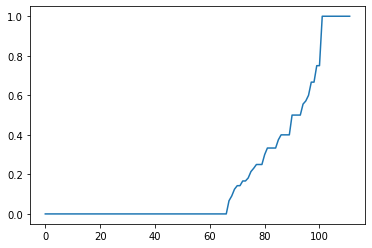

In [141]:
#!g1.1
from matplotlib import pyplot as plt

plt.plot(sorted(accs))

Короче на уровне совпадения позиций классификаторов совпадений крайне мало. Нет смысла дальше использовать эту метрику.

### Fun part

In [46]:
#!g1.1
sentence1 = "Я умею переводить текст на русский жестовый язык."
sentence2 = "Этот текст перевела модель машинного перевода."
to_rsl = [sentence1, sentence2]

In [47]:
#!g1.1
rsl_preds = model2.predict(to_rsl)

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

/home/jupyter/.local/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fcc4a1ffca0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "
/home/jupyter/.local/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fcc4a1ffdc0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "
/home/jupyter/.local/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fcc4a1ffee0> o

Decoding outputs:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jupyter/.local/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fcc4a183a60> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "
/home/jupyter/.local/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fcc4a183b80> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "
/home/jupyter/.local/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fcc4a183ca0> o

In [48]:
#!g1.1
rsl_preds

['я знать переводить текст на русский жестовый язык',
 'перевести текст перевод модель этот машинный перевод']